# First pass, OPTION A

This is the first pass of my TFG, the idea of processing the image and being able to detect features and such


### Loading Libraries

In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
%matplotlib inline
from IPython.display import Image
from tensorflow.keras import models
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
import random as rng
rng.seed(12345)

### Loading data

It is necessary that, before starting the detection of objects we prosses the images so that they are selected and well suited for analizis. That's why we need to separate the cloth from the background. An option might be the use of a machine learning algorithm to detect the cloth from a picture

In [2]:
pant_img_original = cv2.imread(r'GoodUp.jpg')

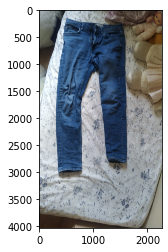

In [3]:
pant_img = pant_img_original[:,:,::-1]
plt.imshow(pant_img)

In [4]:
pant_img_gray = cv2.cvtColor(pant_img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(pant_img_gray, (7, 7), 0)
(thresh, blackAndWhiteImage) = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

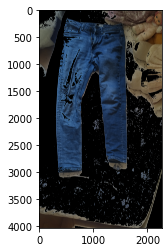

In [5]:
invertedMask = cv2.bitwise_not(blackAndWhiteImage)
newImage = cv2.bitwise_or(pant_img, pant_img, mask = invertedMask)
plt.imshow(newImage)

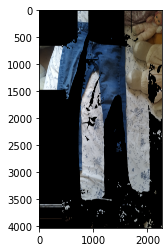

In [6]:
kernelClose = np.ones((10,10),np.uint8)
redoneInverted = invertedMask
for x in range(15):
    redoneInverted = cv2.morphologyEx(redoneInverted, cv2.MORPH_CLOSE, kernelClose)
for x in range(400):
    redoneInverted = cv2.morphologyEx(redoneInverted, cv2.MORPH_OPEN, kernelClose)
newImage = cv2.bitwise_or(pant_img, pant_img, mask = redoneInverted)
plt.imshow(newImage)

We can see here that, by using traditional steps, we cannot get a good enough definition of the pants, and therefore, it is of no use. What we will do instead, is to create a CNN to detect those pants, and later apply wathever it is needed to form it and develop it as needed

# Loading existing model

Once we have the existing model, we can load it up and make the necessay predictions.
Look at: PantsModel_Training.ipynb

In [7]:
model = models.load_model('saved_model/pantsModel_balanced')

In [8]:
def predict(img_name):
    img=image.load_img(img_name,target_size=(224,224))
    img=image.img_to_array(img)
    plt.imshow(img.astype('int32'))
    plt.show()
    prediction=model.predict(img.reshape(1, 224, 224, 3))
    output=np.argmax(prediction)
    print(output)
    return output

In [9]:
pictureRoute = r'GoodUp.jpg'

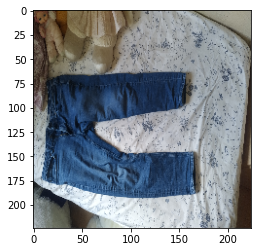

2
Top


In [10]:
result = predict(pictureRoute) #Test prediction
if result == 0:
    print("Long Pants")
elif result == 1:
    print("Short Pants")
elif result == 2:
    print("Top")

In [11]:
if result == 0:
    print("It is a corrent pant form")

Interestingly enough, we get a good output, labeled as long-pants

# Extracting pants from the picture

We are going to apply a heatmap mask from the model and try to extract the pants form

In [12]:
def maskExtraction(orig, model, intensity=0.5, res=224):
    img = image.load_img(orig, target_size=(res, res))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    preds = model.predict(x)
    
    with tf.GradientTape() as tape:
        last_conv_layer = model.get_layer('conv5_block3_out')
        iterate = models.Model([model.inputs], [model.output, last_conv_layer.output])
        model_out, last_conv_layer = iterate(x)
        class_out = model_out[:, np.argmax(model_out[0])]
        grads = tape.gradient(class_out, last_conv_layer)
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    heatmap = heatmap.reshape((7, 7))
    img = cv2.imread(orig)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))  
    heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    return heatmap

C:\Users\pauso\AppData\Local\Temp\ipykernel_11456\1636359510.py:17: RuntimeWarning: invalid value encountered in true_divide
  heatmap /= np.max(heatmap)


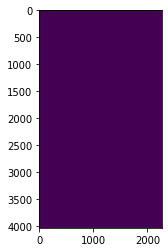

In [13]:
heatmap = maskExtraction(pictureRoute, model)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2GRAY)
plt.imshow(heatmap)
#(thresh, blackAndWhiteImage) = cv2.threshold(heatmap, 0, 255, cv2.THRESH_OTSU)
#invertedMask = cv2.bitwise_not(blackAndWhiteImage)
#plt.imshow(invertedMask)
#newImage = cv2.bitwise_or(pant_img, pant_img, mask = invertedMask)


# Rotation and scaling

For now we are going to work on a new dataset to progress on the project, therefore let's load it

In [14]:
img_original = cv2.imread(r'Data\SimplePants\wide_stereo_optical_frame_birdseye_2010-09-07-21-02-27_thresh.png', cv2.IMREAD_UNCHANGED)
img = img_original[:,:,::-1]
plt.imshow(img)

TypeError: 'NoneType' object is not subscriptable

We would like to rotate to set the correct orientation, as well as to scale the image as needed

In [ ]:
def getBoundingBox(processedImage):
    #We get edges
    canny_output = cv2.Canny(processedImage, 100, 200)
    #We get the contours
    contours, _ = cv2.findContours(canny_output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #We go through the contours and find a box
    drawing = np.copy(processedImage)

    boundRect = [None]*len(contours)
    preferedI = 0
    currentAmount = 0
    for i, c in enumerate(contours):
        boundRect[i] = cv2.boundingRect(c)
        amount = boundRect[i][2]*boundRect[i][3]
        if(amount > currentAmount):
            currentAmount = amount
            preferedI = i
            
    if len(boundRect) <= 0:
        print("Not detected any")
        return boundRect
    theBox = boundRect[preferedI]
    return theBox

In [ ]:
def getDirection(currentBox, previousBox):
    difference= int(previousBox[2])-int(currentBox[2])
    direction = int(np.sign(difference))
    return direction

In [ ]:
def correctRotation(image, size, rotationStep = 1):
    #First we get a simplified version of the image
    src_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    src_gray = cv2.blur(src_gray, (3,3))
    (thresh, blackAndWhiteImage) = cv2.threshold(src_gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    #And we clean it so that it's more easy to work with
    kernelClose = np.ones((size,size),np.uint8)
    blackAndWhiteImage = cv2.bitwise_not(blackAndWhiteImage)
    redoneInverted = cv2.morphologyEx(blackAndWhiteImage, cv2.MORPH_OPEN, kernelClose)
    previousBox = getBoundingBox(redoneInverted)
    
    amountRotated = 0
    newRotation = np.copy(redoneInverted)
    if(previousBox[2] > previousBox[3]):
        print('Height greater than width, applying 90º rotation')
        newRotation = cv2.rotate(redoneInverted, cv2.cv2.ROTATE_90_CLOCKWISE) 
        previousBox = getBoundingBox(newRotation)
        amountRotated -= 90
    print('Finding best rotation')
    
    amountRotated -= rotationStep
    
    directionRotation = 1
    newRotation = imutils.rotate(redoneInverted, amountRotated)
    currentBox = getBoundingBox(newRotation)
    direction = getDirection(currentBox, previousBox)
    amountRotated -= rotationStep*direction
    steps = 0
    while(True):
        steps += 1
        previousBox = np.copy(currentBox)
        newRotation = imutils.rotate(redoneInverted, amountRotated) 
        currentBox = getBoundingBox(newRotation)
        if(previousBox[2] < currentBox[2]):
            break
        amountRotated -= rotationStep*direction
    
    print("Found it in " + str(steps) + " steps. Rotated " + str(amountRotated) + " degrees")
    finalImage = imutils.rotate(image, amountRotated)
    return amountRotated, finalImage, previousBox    

amountRotated, finalImage, finalBox = correctRotation(img,35)
cv2.imshow("FinalProcess", finalImage)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
def cropAndScale(image, boundingBox, targetHeight, margin =5):
    imag = image[boundingBox[1]-margin:boundingBox[1]+boundingBox[3]+margin, 
                 boundingBox[0]-margin:boundingBox[0]+boundingBox[2]+margin]
    return imag

result = cropAndScale(finalImage, finalBox, 400)
cv2.imshow("FinalProcess", result)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Finding shape and normalizing form

The idea is to set it as normal as possible to be able to detect diferent forms or things